In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image
from scipy.ndimage.interpolation import zoom

fname = 'einstein.jpg'
i_width = 640
i_height = 480

# Subsampling the Einstein Photo

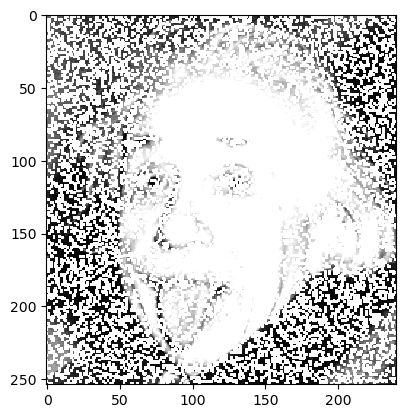

(254, 240)

In [2]:
np.random.seed(42)

sampling_threshold = 0.8

image = zoom(np.asarray(Image.open(fname).convert('L')), 0.2).astype(np.float)

image_ss = image.copy()
mask = np.random.uniform(size = image.shape) < 1 - sampling_threshold
image_ss[mask] = np.nan
plt.imshow(image_ss, cmap = 'gray', vmin = 0, vmax = 225)
plt.show()
image_ss.shape

# Constructing the Training and Validation Set

In [3]:
x_train = []
y_train = []
x_test = []
y_test = []
is_nan = np.isnan(image_ss)
total_nan = is_nan.sum()

for iy, ix in np.ndindex(is_nan.shape):
    if is_nan[iy, ix]:
        x_test.append([iy, ix])
        y_test.append(image[iy, ix])
    else:
        x_train.append([iy, ix])
        y_train.append(image_ss[iy, ix])
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

# Extending the Input Features

In [4]:
def include_adj_pixels(pixels):
    new_dataset = np.empty(shape = (pixels.shape[0], 6))

    shapey, shapex = image_ss.shape

    for i, pixel in enumerate(pixels):
        iy, ix = pixel

        y_up = -999
        y_down = -999
        y_left = -999
        y_right = -999

        if iy in range(1, shapey):
            if not np.isnan(image_ss[iy - 1, ix]):
                y_up = image_ss[iy - 1, ix]
        if iy in range(shapey - 1):
            if not np.isnan(image_ss[iy + 1, ix]):
                y_down = image_ss[iy + 1, ix]

        if ix in range(1, shapex):
            if not np.isnan(image_ss[iy, ix - 1]):
                y_left = image_ss[iy, ix - 1]
        if ix in range(shapex - 1):
            if not np.isnan(image_ss[iy, ix + 1]):
                y_right = image_ss[iy, ix + 1]

        new_dataset[i] = np.array([iy, ix, y_up, y_down, y_left, y_right])
    return new_dataset

new_x_train = include_adj_pixels(x_train)
new_x_test = include_adj_pixels(x_test)

print("We have now created a new train and validation set with the additional features.")

We have now created a new train and validation set with the additional features.


# Random Forest Regressor Cross-Validation and Optimization

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

def RandomForestEvalPipeline(extra_features = False, n_estimators = 100):
    rfreg = RandomForestRegressor(n_estimators = n_estimators)
    
    if extra_features:
        score_rfreg = cross_validate(rfreg, new_x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1
   
    else:
        score_rfreg = cross_validate(rfreg, x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1
    
#     print("The model includes the additional features." if extra_features else "The model does not include the addtional features.")
#     print(f"For the model with {n_estimators} estimators these are the following scores for the 5-fold cross-validation:")
    
#     for i, score in enumerate(score_rfreg):
#         print(f"{i + 1}. {round(score, 2)}")
    
    mean_score_rfreg = score_rfreg.mean()
    
#     print(f"The average score in the cross-validation is {round(mean_score_rfreg, 2)}.")
    return mean_score_rfreg

In [6]:
def GridSearchRandomForest(extra_features = False, n_estimators_vals = [100]):
    min_loss = np.inf
    best_n_estimators = None
    
    for n_estimators_val in n_estimators_vals:
        loss = RandomForestEvalPipeline(extra_features = extra_features, n_estimators = n_estimators_val)
        if loss < min_loss:
            min_loss = loss
            best_n_estimators = n_estimators_val
    return round(min_loss, 2), best_n_estimators

# min_loss, best_n_estimators = GridSearchRandomForest(extra_features = False, n_estimators_vals = [50, 75, 100, 150])
# print(f"The best model has {best_n_estimators} estimators with an average MSE loss {min_loss}. This model does not contain the addtional features.")

# min_loss, best_n_estimators = GridSearchRandomForest(extra_features = True, n_estimators_vals = [50, 75, 100, 150])
# print(f"The best model has {best_n_estimators} estimators with an average MSE loss {min_loss}. This model contains the addtional features.")

# Gradient Boosting Regressor Cross-Validation and Optimization

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

def GradientBoostingEvalPipeline(extra_features = False, n_estimators = 100, learning_rate = 0.01):
    gbreg = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate)
    
    if extra_features:
        score_gbreg = cross_validate(gbreg, new_x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1
    
    else:
        score_gbreg = cross_validate(gbreg, x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1
        
#     print(f"For the model with {n_estimators} estimators and learning rate equal to {learning_rate} these are the following scores for the 5-fold cross-validation:")
    
#     for i, score in enumerate(score_gbreg):
#         print(f"{i + 1}. {round(score, 2)}")
    
    mean_score_gbreg = score_gbreg.mean()
    
#     print(f"The average score in the cross-validation is {round(mean_score_gbreg, 2)}.")
    return mean_score_gbreg

In [8]:
def GridSearchGradientBoosting(extra_features = False, n_estimators_vals = [100], learning_rate_vals = [0.01]):
    min_loss = np.inf
    best_n_estimators, best_learning_rate = None, None
    
    for n_estimators_val in n_estimators_vals:
        for learning_rate_val in learning_rate_vals:
            loss = GradientBoostingEvalPipeline(extra_features = extra_features, n_estimators = n_estimators_val, learning_rate = learning_rate_val)
            if loss < min_loss:
                min_loss = loss
                best_n_estimators = n_estimators_val
                best_learning_rate = learning_rate_val
                
    return round(min_loss, 2), best_n_estimators, best_learning_rate

# min_loss, best_n_estimators, best_learning_rate = GridSearchGradientBoosting(extra_features = False, n_estimators_vals = [50, 75, 100, 150], learning_rate_vals = [0.01, 0.1, 0.3])
# print(f"The best model has {best_n_estimators} estimators and learning rate equal to {best_learning_rate} with an average MSE loss {min_loss}. This model does not contain the addtional features.")

# min_loss, best_n_estimators, best_learning_rate = GridSearchGradientBoosting(extra_features = True, n_estimators_vals = [50, 75, 100, 150], learning_rate_vals = [0.01, 0.1, 0.3])
# print(f"The best model has {best_n_estimators} estimators and learning rate equal to {best_learning_rate} with an average MSE loss {min_loss}. This model contains the addtional features.")



# Gaussian Feature Map Regression Cross-Validation and Optimization

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.kernel_approximation import RBFSampler  
from sklearn.pipeline import Pipeline

def GaussianKernelEvalPipeline(extra_features = False, sigma = 1.0, alpha = 0.0,tol = 1e-4, l1_ratio = 0.5, max_iter = 1000):
    rbf_feature = RBFSampler(gamma = 1 / (2 * (sigma ** 2)), random_state = 42)
    
    elastic_net = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, tol = tol, max_iter = max_iter)
            
    if extra_features:
        norm_new_x_train = MinMaxScaler().fit_transform(new_x_train)
        gauss_new_x_train = rbf_feature.fit_transform(new_x_train)
        score_gaussian_kernel = cross_validate(elastic_net, gauss_new_x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1
    else:
        norm_x_train = MinMaxScaler().fit_transform(x_train)
        gauss_x_train = rbf_feature.fit_transform(x_train)
        score_gaussian_kernel = cross_validate(elastic_net, gauss_x_train, y_train, cv = 5, scoring = 'neg_root_mean_squared_error')['test_score'] * -1

#     print(f"The model with gamma equal to {round(1 / sigma, 2)}, alpha equal to {alpha}, tolerance equal to {tol}, and L1-ratio equal to {l1_ratio} these are the following scores for the 5-fold cross-validation:")
    
#     for i, score in enumerate(score_gaussian_kernel):
#         print(f"{i + 1}. {round(score, 2)}")
    
    mean_score_gaussian_kernel = score_gaussian_kernel.mean()
    
#     print(f"The average score in the cross-validation is {round(mean_score_gaussian_kernel, 2)}.")

    return mean_score_gaussian_kernel 

In [22]:
def GridSearchGaussianKernel(extra_features = False, sigma_vals = [1.0], alpha_vals = None, tol_vals = [1e-4], l1_ratio_vals = [0.5], max_iter_vals = [1000]):
    min_loss = np.inf
    best_sigma, best_alpha, best_tol, best_l1_ratio = None, None, None, None
    count = 0
    for sigma_val in sigma_vals:
        for alpha_val in alpha_vals:
            for tol_val in tol_vals:
                for max_iter_val in max_iter_vals:
                    if alpha_val > 0:
                        for l1_ratio_val in l1_ratio_vals:
                            loss = GaussianKernelEvalPipeline(extra_features = False, sigma = sigma_val, alpha = alpha_val,tol = tol_val, l1_ratio = l1_ratio_val, max_iter = max_iter_val)
                    else:
                        l1_ratio_val = 0.0
                        loss = GaussianKernelEvalPipeline(extra_features = False, sigma = sigma_val, alpha = alpha_val,tol = tol_val, l1_ratio = l1_ratio_val, max_iter = max_iter_val)

                    if loss < min_loss:
                        min_loss = loss
                        best_sigma, best_alpha, best_tol, best_l1_ratio = sigma_val, alpha_val, tol_val, l1_ratio_val
    return round(min_loss, 2), best_sigma, best_alpha, best_tol, best_l1_ratio


In [11]:
# min_loss, best_sigma, best_alpha, best_tol, best_l1_ratio = GridSearchGaussianKernel(extra_features = False, sigma_vals = [1.0, 2.0, 3.0], tol_vals = [1e-4, 1e-3, 1e-2])
# print(f"The best model has sigma value equal to {best_sigma} and tolerance equal to {best_tol} with an average MSE loss {min_loss}. This model does not contain the addtional features.")

# min_loss, best_sigma, best_alpha, best_tol, best_l1_ratio = GridSearchGaussianKernel(extra_features = True, sigma_vals = [1.0, 2.0, 3.0], tol_vals = [1e-4, 1e-3, 1e-2])
# print(f"The best model has sigma value equal to {best_sigma} and tolerance equal to {best_tol} with an average MSE loss {min_loss}. This model does contain the addtional features.")


In [25]:
min_loss, best_sigma, best_alpha, best_tol, best_l1_ratio = GridSearchGaussianKernel(extra_features = True, alpha_vals = [0.0, 0.1, 0.25, 0.5], sigma_vals = [1.0, 2.0, 3.0], tol_vals = [1e-4, 1e-3, 1e-2], l1_ratio_vals = [0.25, 0.5, 0.75], max_iter_vals = [1000, 2500, 5000])
print(f"The best model has sigma value equal to {best_sigma}, tolerance equal to {best_tol}, alpha equal to {best_alpha}, and L1-ratio equal to {best_l1_ratio} with an average MSE loss {min_loss}. This model does contain the addtional features.")


KeyboardInterrupt: 

In [12]:
from sklearn.metrics import mean_squared_error

def RandomForestPredictImage(extra_features = False, n_estimators = 100):
    rfreg = RandomForestRegressor(n_estimators = n_estimators)
    
    if extra_features:
        rfreg.fit(new_x_train, y_train)
        predict_image = rfreg.predict(new_x_test)
    else:
        rfreg.fit(x_train, y_train)
        predict_image = rfreg.predict(x_test)
    
    reconstr_image = np.empty(shape = image.shape)
    
    for i, pixel in enumerate(x_train):
        iy, ix = pixel
        reconstr_image[iy, ix] = y_train[i]
        
    for i, pixel in enumerate(x_test):
        iy, ix = pixel
        reconstr_image[iy, ix] = predict_image[i]
    
    plt.imshow(reconstr_image, cmap = 'gray', vmin = 0, vmax = 225)
    plt.show()
    
    y_test_resh = y_test.reshape(-1, 1)
    y_predict_resh = predict_image.reshape(-1, 1)
    
    mse_score = round(mean_squared_error(y_test_resh, y_predict_resh, squared = False), 2)
    print(f"The MSE for this predicted image is {mse_score}.")
# RandomForestPredictImage(extra_features = True, n_estimators = 100)

In [13]:
def GradientBoostingPredictImage(extra_features = False, n_estimators = 100, learning_rate = 0.01):
    gbreg = GradientBoostingRegressor(n_estimators = n_estimators, loss = 'squared_error', max_depth = 3,learning_rate = learning_rate, random_state = 42)
    
    if extra_features:
        gbreg.fit(new_x_train, y_train)
        predict_image = gbreg.predict(new_x_test)
    
    else:
        gbreg.fit(new_x_train, y_train)
        predict_image = gbreg.predict(new_x_test)
        
    reconstr_image = np.empty(shape = image.shape)
    
    for i, pixel in enumerate(x_train):
        iy, ix = pixel
        reconstr_image[iy, ix] = y_train[i]
        
    for i, pixel in enumerate(x_test):
        iy, ix = pixel
        reconstr_image[iy, ix] = predict_image[i]
    
    plt.imshow(reconstr_image, cmap = 'gray', vmin = 0, vmax = 225)
    plt.show()
    
    y_test_resh = y_test.reshape(-1, 1)
    y_predict_resh = predict_image.reshape(-1, 1)
    
    mse_score = round(mean_squared_error(y_test_resh, y_predict_resh, squared = False), 2)
    print(f"The MSE for this predicted image is {mse_score}.")
# GradientBoostingPredictImage(extra_features = True, n_estimators = 150, learning_rate = 0.3)

In [14]:
def GaussianKernelPredictImage(extra_features = False, sigma = 1.0, alpha = 0.0,tol = 1e-4, l1_ratio = 0.5):
    min_max = MinMaxScaler()
    rbf_feature = RBFSampler(gamma = 1 / (2 * (sigma ** 2)), random_state = 42)
    elastic_net = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, tol = tol)

    if extra_features:
        norm_new_x_train = min_max.fit_transform(new_x_train)
        gauss_new_x_train = rbf_feature.fit_transform(norm_new_x_train)
        elastic_net.fit(gauss_new_x_train, y_train)
        
        norm_new_x_test = min_max.transform(new_x_test)
        gauss_new_x_test = rbf_feature.transform(norm_new_x_test)
        predict_image = elastic_net.predict(gauss_new_x_test)
    
    else:
        min_max = MinMaxScaler()
        norm_x_train = min_max.fit_transform(x_train)
        gauss_x_train = rbf_feature.fit_transform(norm_x_train)
        elastic_net.fit(gauss_x_train, y_train)
        
        norm_x_test = min_max.transform(x_test)
        gauss_x_test = rbf_feature.transform(norm_x_test)
        predict_image = elastic_net.predict(gauss_x_test)
    
    reconstr_image = np.empty(shape = image.shape)
    
    for i, pixel in enumerate(x_train):
        iy, ix = pixel
        reconstr_image[iy, ix] = y_train[i]
        
    for i, pixel in enumerate(x_test):
        iy, ix = pixel
        reconstr_image[iy, ix] = predict_image[i]
    
    plt.imshow(reconstr_image, cmap = 'gray', vmin = 0, vmax = 225)
    plt.show()
    
    y_test_resh = y_test.reshape(-1, 1)
    y_predict_resh = predict_image.reshape(-1, 1)
    
    mse_score = round(mean_squared_error(y_test_resh, y_predict_resh, squared = False), 2)
    print(f"The MSE for this predicted image is {mse_score}.")
# GaussianKernelPredictImage(extra_features = True)

# Exponential Kernel Features

In [9]:
from sklearn.base import TransformerMixin 
from sklearn.base import BaseEstimator 
class ExpKernelFeatures(TransformerMixin,BaseEstimator):
    def __init__(self, locations, exp_lambda = 1):
        self.locations = locations
        self.exp_lambda = exp_lambda
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        y = X.shape[0]
        x = len(self.locations)
        
        exp_features = np.empty(shape = (y, x))
        
        for i, data in enumerate(X):
            exp_data = np.exp(-1 * self.exp_lambda * np.absolute(self.locations - data))
            exp_features[i] = exp_data
        return exp_features
    
grid_points = np.linspace(-2.0, 2.0, num = 10)
x_predict = np.linspace(-2.0, 2.0, num = 10000)

exp_ker = ExpKernelFeatures(locations = grid_points, exp_lambda = 4)

exp_features = exp_ker.transform(x_predict)
# plt.figure(figsize = (12, 8))
# plt.plot(x_predict, exp_features)
# plt.title('Exponential Features with Lambda Equal to 4')
# plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.uniform(low = -2, high = 2, size = 500)

model = 'polynomial'

if model == 'polynomial':
    y = 2. + 2 * X + 0.4 * X ** 2 - 0.4 * X ** 3
elif model == 'periodic':
    y = np.sin(20 * np.pi * 0.1 * X)
    
X = X[:, np.newaxis]

error = 0.2 * np.random.randn(y.shape[0])
y += error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
x_predict = np.linspace(-2, 2, 1000)

In [11]:
np.random.seed(42)
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor, HuberRegressor

estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept = False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state = 42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state = 42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor())]

# fig, ax = plt.subplots(1, 1, figsize = (16, 8))

# ax.plot(X_train, y_train, 'o', c = 'black')
# for label, style, color, estimator in estimators:
#     model = estimator
#     model.fit(exp_ker.transform(X_train), y_train)
#     mse = mean_squared_error(y_test, model.predict(exp_ker.transform(X_test)))
#     y_pol_pred = model.predict(exp_ker.transform(x_predict[:, None]))
#     ix = np.argsort(x_predict)
#     plt.plot(x_predict[ix], y_pol_pred[ix], style, lw = 2, color = color, label = label + f" E = {round(mse, 2)}")
# plt.legend(loc = 'upper right', framealpha = 0.95)
    

# Generating Brownian Motion

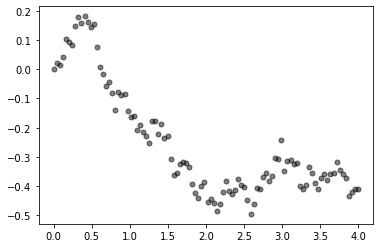

In [12]:
np.random.seed(42)

time = np.linspace(0, 4, 100)

dt = time[1] - time[0]

W = np.zeros(100)

for i in range(1, 100):
    W[i] = W[i - 1] + np.random.normal(loc = 0, scale = dt)
    
plt.plot(time, W, 'o', ms = 5, color = 'black', alpha = 0.5)

# plt.plot(t, brownian_motion)
# plt.xlabel("Time (t)")
# plt.title("Brownian Motion Path")
# plt.show()

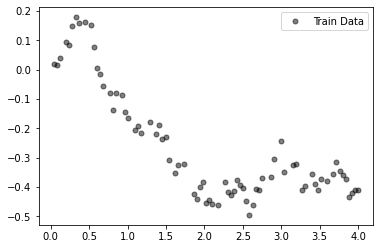

In [13]:
X = time[:, np.newaxis]
y = W

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

x_predict = np.linspace(0, 4, 1000)

plt.plot(X_train, y_train, 'o', ms = 5, color = 'black', alpha = 0.5, label = 'Train Data')
plt.legend()


Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__exp_lambda': 0.1} with optimal MSE CV score -0.0031863981794894385 and MSE error 0.0032594342192285275 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__exp_lambda': 0.5} with optimal MSE CV score -0.005108313276722643 and MSE error 0.003707634935658181 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(min_samples=0.75, random_state=42) is {'ExpFeatures__exp_lambda': 0.1} with optimal MSE CV score -0.0039082011083076615 and MSE error 0.0037562211223880577 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: HuberRegressor(max_iter=10000) is {'ExpFeatures__exp_lambda'

/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

The optimal lambda for estimator: HuberRegressor(max_iter=10000) is {'ExpFeatures__exp_lambda': 0.1} with optimal MSE CV score -0.00147890625573791 and MSE error 0.0008296023355245873 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__exp_lambda': 5} with optimal MSE CV score -0.0013901416379382748 and MSE error 0.0008912628032198948 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__exp_lambda': 5} with optimal MSE CV score -0.0013796259107502246 and MSE error 0.0008765285263376381 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(min_samples=0.75, random_state=42) is {'ExpFeatures__exp_lambda': 5} with optimal MSE CV score -0.001351124695333225 and MSE err

/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

The optimal lambda for estimator: HuberRegressor(max_iter=10000) is {'ExpFeatures__exp_lambda': 0.1} with optimal MSE CV score -0.0013664151393817966 and MSE error 0.0007054155598634918 for the test set



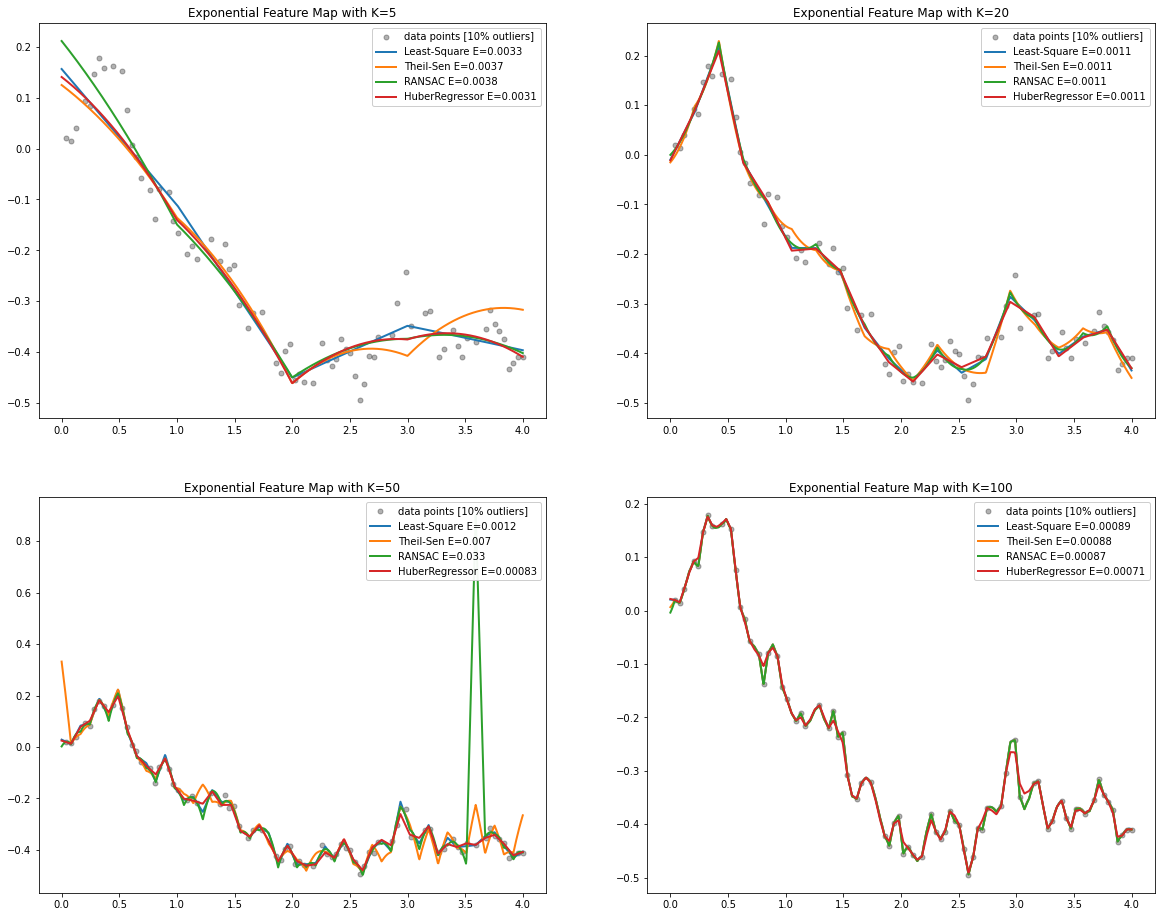

In [14]:
np.random.seed(42)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42, min_samples=0.75)),
              ('HuberRegressor', '-', 'C3', HuberRegressor(max_iter=10000))]
fig2, axs = plt.subplots(2, 2, figsize=(20, 16))
axs[0,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[0,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[1,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]') 
axs[1,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
plot_i = 0  # For finding the right plot

plot_list=[(0,0), (0,1), (1,0), (1,1)]


for K in [5, 20, 50, 100]:
    K_grid_points = np.linspace(0, 4, K)    
    for label, style, color, estimator in estimators:

        grid_params = {
            'ExpFeatures__exp_lambda': [0.1, 0.5, 1, 2, 3, 4, 5]
        }

        # Build Pipeline
        gs_ExpFeatures = GridSearchCV(
            Pipeline([('ExpFeatures', ExpKernelFeatures(locations = K_grid_points)),
                      ('estimator', estimator)
            ]),
            grid_params,
            scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
            verbose = 1,  # set to 1 is equivalent to no bs
            cv = 5,       # (Stratified) 5-Fold Cross-Validation
            n_jobs=2      # use 2 processors
        )
        
        # Fit the train_set
        gs_ExpFeatures_results = gs_ExpFeatures.fit(X_train, y_train)

        # notes down the optimal score, optimal model and optimal lambda
        optimal_score=gs_ExpFeatures_results.best_score_
        optimal_lambda=gs_ExpFeatures_results.best_params_
        optimal_model=gs_ExpFeatures_results.best_estimator_

        # Compute the error between the values predicted by the optimal model
        # and true values (y_test) on the test set
        mse_exp = mean_squared_error(optimal_model.predict(X_test), y_test)
        
        print(f'The optimal lambda for estimator: {estimator} is {optimal_lambda} with optimal MSE CV score {optimal_score} and MSE error {mse_exp} for the test set\n')

        y_predicted_exp = optimal_model.predict(x_predict[:, None])
        ix = np.argsort(x_predict)
        axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
                color=color, label=label + ' E={:2.2g}'.format(mse_exp))

    axs[plot_list[plot_i]].legend(loc='upper right', framealpha=0.95)
    axs[plot_list[plot_i]].set_title(f'Exponential Feature Map with K={K}')
    plot_i = plot_i + 1
plt.show()

# Predicting Brownian Motion Path Using Exponential Feature Map Regression

In [15]:
def k_grid_points(k):
    return np.linspace(0, 4, k)

def ExpPredictBrownianMotion(k, exp_lambda, color):
    model = LinearRegression()

    locations = k_grid_points(k)
    exp_ker = ExpKernelFeatures(locations = locations, exp_lambda = exp_lambda)
    exp_feat = exp_ker.transform(t)

    model.fit(exp_feat, brownian_motion)

    brownian_motion_predict = model.predict(exp_feat)
    
    mse = round(mean_squared_error(brownian_motion, brownian_motion_predict, squared = False), 4)
    
    plt.figure(figsize= (4, 3))
    plt.plot(t, brownian_motion, c = 'black')
    plt.plot(t, brownian_motion_predict, c = 'C'+str(color), label = f'Lambda = {exp_lambda}')
    plt.legend(loc = 'upper right')
    plt.xlabel("Time (t)")
    plt.title(f"Lambda = {exp_lambda}, MSE = {mse}")

# Results for Varying Lamba and Number of Landmarks (Grid Points)

In [16]:
# for i, exp_lambda in enumerate([0.1, 0.5, 0.75, 1, 2, 3, 4, 5, 6]):
#     ExpPredictBrownianMotion(5, exp_lambda, i + 1)

In [17]:
# for i, exp_lambda in enumerate([0.1, 0.5, 0.75, 1, 2, 3, 4, 5, 6]):
#     ExpPredictBrownianMotion(20, exp_lambda, i + 1)

In [18]:
# for i, exp_lambda in enumerate([0.1, 0.5, 0.75, 1, 2, 3, 4, 5, 6]):
#     ExpPredictBrownianMotion(50, exp_lambda, i + 1)

In [19]:
# for i, exp_lambda in enumerate([0.1, 0.5, 0.75, 1, 2, 3, 4, 5, 6]):
#     ExpPredictBrownianMotion(100, exp_lambda, i + 1)